In [1]:
# !conda install -c conda-forge librosa

# !conda install tqdm

In [2]:
import torch as ch
import torch.nn as nn
import torch.functional as F
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa

import tqdm

import torch.utils.data as Data
import datasets

In [3]:
import shutil

In [4]:
class C(ch.nn.Module):
    def __init__(self,o,i,k,d,causal,s=1):
        super(C,self).__init__()
        self.causal = causal
        assert (k-1)%2 == 0 
        if causal:
            self.pad = (k-1)*d
        else:
#             print('filter',k,'dilation',d,'total pad',(k-1)*d,'half pad',(k-1)*d//2)
            self.pad = (k-1)*d // 2 
        self.conv = ch.nn.Conv1d(out_channels=o, in_channels=i,
                    kernel_size=k, dilation=d, stride=s, padding=self.pad)
        ch.nn.init.kaiming_normal_(self.conv.weight.data)
        self.dilation = d
    
    def forward(self,X):
        O = self.conv(X)
        return O[:,:,:-self.pad] if self.causal and self.pad else O

In [5]:
class Cs(ch.nn.Module):
    def __init__(self,o,i,k,d,causal,s=1):
        super(C,self).__init__()
        self.causal = causal
        assert (k-1)%2 == 0 
        if causal:
            self.pad = (k-1)*d
        else:
            self.pad = (k-1)*d // 2 
#         self.conv = ch.nn.Conv1d(out_channels=o, in_channels=i,
#                     kernel_size=k, dilation=d, stride=s, padding=pad)
        self.depthwise = ch.nn.Conv1d(out_channels=i, in_channels=i,
                        kernel_size=k, dilation=d, stride=s,
                        padding=self.pad, groups=i)
        self.pointwise = ch.nn.Conv1d(out_channels=o, in_channels=i,kernel_size=1)
        ch.nn.init.kaiming_normal_(self.depthwise.weight.data)
        ch.nn.init.kaiming_normal_(self.pointwise.weight.data)
    
    def forward(self,X):
        O = self.pointwise(self.depthwise(X))
        return O[:,:,:-self.pad] if self.causal else O

In [6]:
class Css(ch.nn.Module):
    def __init__(self,o,i,k,d,causal,s=1):
        super(C,self).__init__()
        self.causal = causal
        assert (k-1)%2 == 0 
        if causal:
            self.pad = (k-1)*d
        else:
            self.pad = (k-1)*d // 2 
#         self.conv = ch.nn.Conv1d(out_channels=o, in_channels=i,
#                     kernel_size=k, dilation=d, stride=s, padding=pad)
        self.depthwise = ch.nn.Conv1d(out_channels=i, in_channels=i,
                        kernel_size=k, dilation=d, stride=s,
                        padding=self.pad, groups=i)
        self.pointwise = ch.nn.Conv1d(out_channels=o, in_channels=i,
                                      kernel_size=1, groups=4)
        ch.nn.init.kaiming_normal_(self.depthwise.weight.data)
        ch.nn.init.kaiming_normal_(self.pointwise.weight.data)
    
    def forward(self,X):
        O = self.pointwise(self.depthwise(X))
        return O[:,:,:-self.pad] if self.causal else O

In [7]:
conv = C(8,4,3,1,0)
conv(ch.rand(3,4,10)).shape

torch.Size([3, 8, 10])

In [8]:
class D(ch.nn.Module):
    def __init__(self,o,i,k,d,causal=0,s=2):
        super(D,self).__init__()
        self.tconv = ch.nn.ConvTranspose1d(out_channels=o, in_channels=i, 
                       kernel_size=k, dilation=d, stride=s)
        ch.nn.init.kaiming_normal_(self.tconv.weight.data)
    
    def forward(self,X):
        return self.tconv(X)

In [9]:
class HC(ch.nn.Module):
    def __init__(self,o,i,k,d,causal,s=1):
        assert o == i
        super(HC,self).__init__()
        self.o = o
        self.conv = C(2*o,i,k,d,causal,s)

    def forward(self,X):
        H = self.conv(X)
        H1,H2 = H[:,:self.o,:],H[:,self.o:,:]
        G = ch.sigmoid(H1)
        return G*H2 + (1-G)*X

In [10]:
class TextEnc(ch.nn.Module):
    def __init__(self,d,e,c2i):
        super(TextEnc,self).__init__()
        c = 0 # non causal
        self.embed = ch.nn.Embedding(len(c2i),e)
        ch.nn.init.kaiming_normal_(self.embed.weight.data)
        layers = [C(2*d,e,1,1,c),ch.nn.ReLU(),C(2*d,2*d,1,1,c)]
        for _ in range(2):
            layers += [HC(2*d,2*d,3,3**ldf,c) for ldf in range(4)]
        layers += [HC(2*d,2*d,3,1,c) for _ in range(2)]
        layers += [HC(2*d,2*d,1,1,c) for _ in range(2)]
        self.seq = ch.nn.Sequential(*layers)
    
    def forward(self,L):
        # permute b/c next layer expects dims to be [batch,embed,seq]
        # output of embed layer is [batch,seq,embed]
#         print(L.shape,self.embed(L).shape)
#         print(self.embed(L).permute(0,2,1).shape)
        return self.seq(self.embed(L).permute(0,2,1))

In [11]:
class AudioEnc(ch.nn.Module):
    def __init__(self,d,F):
        super(AudioEnc,self).__init__()
        c = 1 # causal
        layers = [C(d,F,1,1,c),ch.nn.ReLU(),C(d,d,1,1,c),ch.nn.ReLU(),C(d,d,1,1,c)]
        for _ in range(2):
            layers += [HC(d,d,3,3**ldf,c) for ldf in range(4)]
        layers += [HC(d,d,3,3,c) for _ in range(2)]
        self.seq = ch.nn.Sequential(*layers)
        
    def forward(self,S):
        return self.seq(S)

In [12]:
class Text2Mel(ch.nn.Module):
    def __init__(self,d,e,c2i,F):
        super(Text2Mel,self).__init__()
        self.d = d
        self.textEnc = TextEnc(d,e,c2i)
        self.audioEnc = AudioEnc(d,F)
    
    def forward(self,L,S):
        KV = self.textEnc(L)
        K,V = KV[:,:self.d,:],KV[:,self.d:,:]
        Q = self.audioEnc(S[:,:,:])
#         print('K',K.shape,'V',V.shape,'Q',Q.shape)
        A = ch.nn.Softmax(dim=1)(ch.matmul(ch.transpose(K,-1,-2),Q) / self.d**0.5)
        R = ch.matmul(V,A)
#         print('R',R.shape,'Q',Q.shape)
        return ch.cat([R,Q],dim=1),A

In [13]:
class AudioDec(ch.nn.Module):
    def __init__(self,d,F):
        super(AudioDec,self).__init__()
        s = 1 # causal
        layers = [C(d,2*d,1,1,s)]
        for _ in range(1): #?
            layers += [HC(d,d,3,3**ldf,s) for ldf in range(4)]
        layers += [HC(d,d,3,1,s) for _ in range(2)]
        for _ in range(3): 
            layers += [C(d,d,1,1,s),ch.nn.ReLU()]
        layers += [C(F,d,1,1,s),ch.nn.Sigmoid()]
        self.seq = ch.nn.Sequential(*layers)
    
    def forward(self,Rp):
        return self.seq(Rp)

In [14]:
class SSRN(ch.nn.Module):
    def __init__(self,c,F,Fp):
        super(SSRN,self).__init__()
        s = 0 # non causal
        layers = [C(c,F,1,1,s)]
        for _ in range(1): #?
            layers += [HC(c,c,3,1,s),HC(c,c,3,3,s)]
        for _ in range(2):
            layers += [D(c,c,2,1),HC(c,c,3,1,s),HC(c,c,3,3,s)]
        layers += [C(2*c,c,1,1,s)]
        layers += [HC(2*c,2*c,3,1,s) for _ in range(2)]
        layers += [C(Fp,2*c,1,1,s)]
        for _ in range(2):
            layers += [C(Fp,Fp,1,1,s),ch.nn.ReLU()]
        layers += [C(Fp,Fp,1,1,s),ch.nn.Sigmoid()]
        self.seq = ch.nn.Sequential(*layers)
    
    def forward(self,Y):
        return self.seq(Y)

In [15]:
# conv = C(3,2,3,1,0)
# tconv = D(3,2,2,1,2)
# hconv = HC(2,2,3,1,0)
# I.shape,conv(I).shape,tconv(I).shape,hconv(I).shape

In [16]:
class params:
    sep = 0
    alpha = 0.5
    d = int(256*alpha)
    e = int(128*alpha)
    c2i = datasets.LJSpeechDataset().c2i
    c = int(512*alpha)
    F = 80
    Fp = 513
    
    g=0.2
    
    lr = 2e-4
    init_lr=2e-4
    b1 = 0.5
    b2 = 0.9
    eps = 1e-6
    
    logevery = 200
    
    dropout_rate = 0.1
    masking = False
    
    gamma = 0.6
    eta = 1.3
    nFFT = 1024
    hopL = 256
    nMel = 80

In [17]:
# # textEnc = TextEnc(d=d,e=e,c2i=c2i)
# # audioEnc = AudioEnc(d=d,F=F)
# audioDec = AudioDec(d=params.d,F=params.F).to(dev)
# ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
# text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

# # alpha = 0.5, super-separable
# [sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,audioDec,ssrn)]

In [18]:
ch.cuda.current_device()
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
ch.multiprocessing.set_start_method("spawn",force=True)

In [19]:
class DbinLoss(ch.nn.Module):
    def __init__(self):
        super(DbinLoss,self).__init__()
    
    def forward(self,Yhat,Y):
        EPS = 1e-12
        elLoss = -(Y*ch.log(Yhat+EPS)+(1-Y)*ch.log(1-Yhat+EPS))
#         return elLoss.view(elLoss.shape[0],-1).mean(1)
        return elLoss.mean()

In [20]:
class GAttLoss(ch.nn.Module):
    def __init__(self):
        super(GAttLoss,self).__init__()
            
    def forward(self,A):
        _,N,T = A.shape
        W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*params.g**2)) 
                        for t in range(1,T+1)] 
                       for n in range(1,N+1)])
        W = W.to(dev)
        return ((1-W)*A).mean()

In [21]:
L1Fun = ch.nn.L1Loss()
BCEFun = ch.nn.BCELoss()
def MelFun(Shat,S): return L1Fun(Shat,S) + BCEFun(Shat,S)
DbinFun = DbinLoss()
GAttFun = GAttLoss()

In [22]:
def saveChkpt(state,model,root='.'):
#     chkptDir = os.path.join(root,'CHKPT'+''.join(p+str(v) for p,v in state['archparams']))
    chkptDir = root
    chkptPath = os.path.join(chkptDir,model+'Chkpt.pth.tar')
    bestPath = os.path.join(chkptDir,model+'Best.pth.tar')
    if not os.path.exists(chkptDir): os.makedirs(chkptDir)    
    ch.save(state,chkptPath)
    if state['lossHist'][-1] == state['bestLoss']:
        shutil.copyfile(chkptPath,bestPath)
    print("SAVED EPOCH {}, LOSS {}, BEST LOSS {}".format(state['epoch'],state['lossHist'][-1],state['bestLoss']))

In [23]:
def loadChkpt(networks,optimizer,model,root='.'):
    # return epoch num and best loss of checkpoint
    chkptDir = root
    chkptPath = os.path.join(chkptDir,model+'Chkpt.pth.tar')
    bestPath = os.path.join(chkptDir,model+'Best.pth.tar')
    if not os.path.exists(chkptPath): return 0,[],float('inf')
    state = ch.load(chkptPath)
    if model == 'text2Mel':
        text2Mel,audioDec = networks
        text2Mel.load_state_dict(state['text2MelState'])
        audioDec.load_state_dict(state['audioDecState'])
    elif model == 'ssrn':
        ssrn, = networks
        ssrn.load_state_dict(state['ssrnState'])
    optimizer.load_state_dict(state['optimizerState'])
    if len(state['lossHist']) > 10: plt.plot(state['lossHist'])
    print("LOADED EPOCH {}, LOSS {}, BEST LOSS {}".format(state['epoch'],state['lossHist'][-1],state['bestLoss']))
    return state['epoch'],state['lossHist'],state['bestLoss']

In [24]:
import datasets
from importlib import reload
reload(datasets)

text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=8)

audioDec = AudioDec(d=params.d,F=params.F).to(dev)
text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

text2MelOpt = ch.optim.Adam(set(text2Mel.parameters())|set(audioDec.parameters()),
                          lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 1
if load:
    startEpoch,lossHist,bestLoss = loadChkpt((text2Mel,audioDec),text2MelOpt,'text2Mel')
else:
    # COLD START - RESET text2Mel
    audioDec = AudioDec(d=params.d,F=params.F).to(dev)
    text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)
    text2MelOpt = ch.optim.Adam(set(text2Mel.parameters())|set(audioDec.parameters()),
                      lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

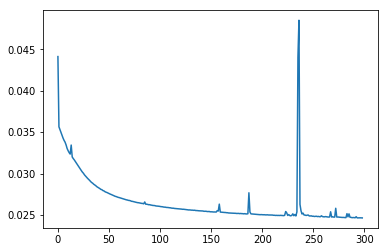

In [26]:
plt.plot(lossHist[2:])

In [27]:
startEpoch = len(lossHist)
train = 0 
for epoch in range(startEpoch,startEpoch+300*train):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(batchL,batchS,_) in tqdm.tqdm_notebook(enumerate(text2MelLoader)):
        batchL = batchL.to(dev)
        batchS = batchS.to(dev)
        bL = ch.autograd.Variable(batchL)
        bS = ch.autograd.Variable(batchS)
        Rp,A = text2Mel(bL,bS)
        Shat = audioDec(Rp)
        melloss = MelFun(Shat[:,:,:-1],bS[:,:,1:])
        attloss = GAttFun(A)
        loss = melloss + attloss
        epochLoss.append(loss.data.item())
        text2MelOpt.zero_grad()
        loss.backward()
        text2MelOpt.step()
#         if step > 10: break
    lossHist.append(np.mean(epochLoss))
    print('epoch',epoch,'total',lossHist[-1],
      'mel',melloss.data.item(),'att',attloss.data.item())
    if epoch % 10 == 0:
        state = {
            'epoch': epoch + 1,
            'archparams': {'sep': params.sep, 'alpha': params.alpha},
            'text2MelState': text2Mel.state_dict(),
            'audioDecState': audioDec.state_dict(),
            'lossHist': lossHist,
            'bestLoss': min(lossHist[-1],bestLoss),
            'optimizerState': text2MelOpt.state_dict() 
        }
        saveChkpt(state,model='text2Mel')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Shat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)

In [28]:
batchS.shape

NameError: name 'batchS' is not defined

LOADED EPOCH 51, LOSS 0.1000639416833422, BEST LOSS 0.1000639416833422


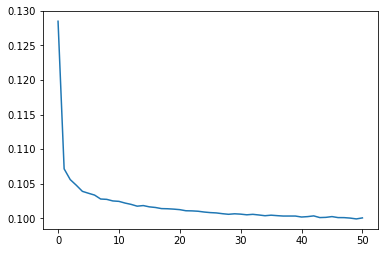

In [29]:
import datasets
from importlib import reload
reload(datasets)

ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=8)

ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)

ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 1
if load:
    startEpoch,lossHist,bestLoss = loadChkpt((ssrn,),ssrnOpt,'ssrn')
else:
    # COLD START - RESET SSRN
    ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
    ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

In [30]:
startEpoch = len(lossHist)
train = 0
for epoch in range(startEpoch,startEpoch+50*train):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(_,batchS,batchY) in tqdm.tqdm_notebook(enumerate(ssrnLoader)):
        batchS = batchS.to(dev)
        batchY = batchY.to(dev)
        bS = ch.autograd.Variable(batchS)
        bY = ch.autograd.Variable(batchY)
        Yhat = ssrn(bS)
        loss = MelFun(Yhat,bY)
        epochLoss.append(loss.data.item())
        ssrnOpt.zero_grad()
        loss.backward()
        ssrnOpt.step()
    lossHist.append(np.mean(epochLoss))
    print('epoch',epoch,'total',np.mean(lossHist))
    if epoch % 10 == 0:
        state = {
            'epoch': epoch + 1,
            'archparams': {'sep': params.sep, 'alpha': params.alpha},
            'ssrnState': ssrn.state_dict(),
            'lossHist': lossHist,
            'bestLoss': min(lossHist[-1],bestLoss),
            'optimizerState': ssrnOpt.state_dict() 
        }
        saveChkpt(state,model='ssrn')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(bY[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)

In [34]:
L,S,Y = datasets.LJSpeechDataset(ttmel=1).__getitem__(1)
L.shape,S.shape,Y.shape

In [36]:
# !pip install lws
import lws
import IPython.display as ipd

In [31]:
dev = 'cpu'

In [32]:
text = "Bears. Beets. Battlestar Galactica".lower()
L = ch.Tensor([params.c2i[c] for c in text]).type(ch.LongTensor).to(dev).unsqueeze(0)
# initial audio enc
s0 = ch.zeros((80,1)).to(dev).unsqueeze(0)
S = s0

In [33]:
text2Mel = text2Mel.to(dev)
audioDec = audioDec.to(dev)
ssrn = ssrn.to(dev)

In [34]:
for t in tqdm.tqdm_notebook(range(100)):
    Rp,A = text2Mel(L,S)
    Shat = audioDec(Rp)
    S = ch.cat((s0,Shat),dim=2)

In [37]:
Y = ssrn(S)
# Y[Y<0] = 0 # doesn't happen
Y = Y ** (params.eta / params.gamma) * 50
Y = Y.cpu().detach().numpy().astype(np.float64)
Y = Y[0].T
Y[Y<0] = 0

lwsProc = lws.lws(params.nFFT,params.hopL,mode='speech',fftsize=params.nFFT)
Y = lwsProc.run_lws(Y)
Y = lwsProc.istft(Y)

In [1]:
ipd.Audio(Y,rate=22050)

plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(S[0].cpu().detach().numpy(),cmap='gray')
plt.show()

NameError: name 'ipd' is not defined